## Let's do some real estate data-sourcing

We have 3 basic data sources:

[Merged Sales](data/zip/merged_sales_stats.csv) - This is sales data by zip code for California. It came from https://www.redfin.com/news/data-center/ and it's got a lot of stats in there. Most of the data is medians so it doesn't tell us much about the outliers which almost certainly are skewing some of the data pretty heavily. There's a lot of mansions in California. The Price per SQ Foot is one way to see a little bit of how the market is shaped. These are broken out by zip code and month.

[Merged Bedrooms](data/zip/merged_bedrooms.csv) - This is also sales data but broken out by the number of bedrooms in the property. That helps us get some sense of how the market is shaped, though of course there are probably $4M one bedrooms skewing things, likely most of those are small condos/townhomes, and we get a little more of a histogram-ish view of the market. These are also broken out by zip code and month though confusingly, in a way that's different than merged sales.

[ca_demographics](data/zip/ca_demographics.csv) - This is 2019 demographic info about the counties in CA. It has tons of info on the county but we need to look up what county a zip code is in for this to be useful. There's examples of that below. What this tends to tell us is "urban/rural", "high income/lower income", really simple categorizations. I might be able to dig up more data by zip code but it's likely to be a bit older. Examples of how to do this are below.

In [1]:
import pandas as pd
import numpy as np
import pandasql as ps
import matplotlib.pyplot as plt


from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

np.random.seed(0)

In [2]:
#load dataframe from csv
merged_sales = pd.read_csv("data/zip/merged_sales_stats.csv", delimiter='	')

#print dataframe shape
shape = merged_sales.shape
print('\nDataFrame Shape :', shape)

print(merged_sales.columns)


DataFrame Shape : (137166, 23)
Index(['Unnamed: 0', 'Zip Code', 'Month of Period End', 'Median Sale Price',
       'Median Sale Price MoM ', 'Median Sale Price YoY ', 'Homes Sold',
       'Homes Sold MoM ', 'Homes Sold YoY ', 'New Listings',
       'New Listings MoM ', 'New Listings YoY ', 'Inventory', 'Inventory MoM ',
       ' Inventory YoY ', 'Days on Market', 'Days on Market MoM',
       'Days on Market YoY', 'Average Sale To List',
       'Average Sale To List MoM ', 'Average Sale To List YoY ',
       'record_month', 'PSSF'],
      dtype='object')


The merged_sales_statistics file has all the statistics as columns and zip codes and dates as the rows. I tried to transpose these but it got weird. So let's get some stuff from the merged_sales:

In [3]:
zip90001 = merged_sales[merged_sales['Zip Code'] == 90001] #zip codes are ints
zip90001.head(2)

,Unnamed: 0,Zip Code,Month of Period End,Median Sale Price,Median Sale Price MoM,Median Sale Price YoY,Homes Sold,Homes Sold MoM,Homes Sold YoY,New Listings,...,Inventory MoM,Inventory YoY,Days on Market,Days on Market MoM,Days on Market YoY,Average Sale To List,Average Sale To List MoM,Average Sale To List YoY,record_month,PSSF
0,0,90001,February 2012,175000,0.0,-7.9,55,-17.9,-6.8,90.0,...,-15.1,-13.5,62.0,27.0,-17.0,95.7,-0.8,-4.5,Zip Code: 900012012-02-01,140.0
1,1,90001,March 2012,165000,-5.7,-8.3,60,9.1,-1.6,92.0,...,-3.3,-5.4,61.0,-1.0,10.0,96.1,0.5,-3.2,Zip Code: 900012012-03-01,145.0


In [4]:
august19 = merged_sales[merged_sales['Month of Period End'] == "August 2019"] #months are strings
august20 = merged_sales[merged_sales['Month of Period End'] == "August 2020"] #months are strings

print(august19['Days on Market'].describe())
print(august20['Days on Market'].describe())

count    1347.000000
mean       48.662955
std        45.229537
min         1.000000
25%        24.000000
50%        41.000000
75%        56.000000
max       654.000000
Name: Days on Market, dtype: float64
count    1338.000000
mean       45.663677
std        46.115726
min         2.000000
25%        22.000000
50%        37.000000
75%        52.000000
max       678.000000
Name: Days on Market, dtype: float64


In [5]:
print(august19['Average Sale To List'].describe())
print(august20['Average Sale To List'].describe())


count    1348.000000
mean       99.470178
std         4.338202
min        78.400000
25%        98.200000
50%        99.300000
75%       100.100000
max       179.000000
Name: Average Sale To List, dtype: float64
count    1339.000000
mean       99.586482
std         2.821165
min        70.300000
25%        98.700000
50%        99.800000
75%       100.500000
max       119.400000
Name: Average Sale To List, dtype: float64


In [6]:


#load dataframe from csv
merged_bedroom_data = pd.read_csv("data/zip/merged_bedrooms.csv", delimiter='	')
print(merged_bedroom_data.shape)
print(merged_bedroom_data.columns)


(1688, 682)
Index(['Unnamed: 0', 'Zip Code', 'June 2009 1bd', 'July 2009 1bd',
       'August 2009 1bd', 'September 2009 1bd', 'October 2009 1bd',
       'November 2009 1bd', 'December 2009 1bd', 'January 2010 1bd',
       ...
       'December 2019 5bd', 'January 2020 5bd', 'February 2020 5bd',
       'March 2020 5bd', 'April 2020 5bd', 'May 2020 5bd', 'June 2020 5bd',
       'July 2020 5bd', 'August 2020 5bd', 'September 2020 5bd'],
      dtype='object', length=682)


In [7]:
# let's get all bedrooms for all zipcodes for August 2020
aug2020_bedrooms = pd.DataFrame(merged_bedroom_data, columns=["Zip Code", "August 2020 1bd", "August 2020 2bd", "August 2020 3bd", "August 2020 4bd", "August 2020 5bd"])

In [8]:
# what's our dataframe look like?
aug2020_bedrooms.head(5)

,Zip Code,August 2020 1bd,August 2020 2bd,August 2020 3bd,August 2020 4bd,August 2020 5bd
0,94109,852358.0,1359790.0,2061146.0,4374846.0,6729337.0
1,90250,495890.0,646922.0,698144.0,782495.0,902262.0
2,94565,227150.0,333446.0,368518.0,514257.0,669362.0
3,90046,595040.0,1058531.0,1919896.0,2830699.0,3621369.0
4,94501,461911.0,863668.0,1145287.0,1317371.0,1619572.0


In [9]:
pd.options.display.float_format = '{:.4f}'.format
# how do we find out things about just 4 bedroom houses in Aug 2020?
aug2020_bedrooms["August 2020 4bd"].describe() 

count      1550.0000
mean     845059.2310
std      738127.1771
min       69945.0000
25%      401323.7500
50%      621232.5000
75%      985655.7500
max     6528913.0000
Name: August 2020 4bd, dtype: float64

In [14]:
''' 
now for our demographic info, it's from 2019 so not super up to date, but pretty close and there's a lot of it
'''
demographics = pd.read_csv("data/zip/ca_demographics.csv", delimiter='	')
zip_to_county = pd.read_csv("data/zip/zip_to_county.csv", delimiter='	')

print(demographics.shape) # a lot of blank columns

# for ind in demographics.columns:
#     print(ind)

(41, 207)


Most of the column names are gibberish, so we'll need to use the [ca_demographics_key.txt](data/zip/ca_demographics_key.txt) to make sense of them.

In [15]:
zip_to_county.columns # more straightforward

Index(['Zip Code', 'State', 'County'], dtype='object')

In [16]:
'''
Ok, so let's find out some things about 90001, more or less.
First, which county is it in?
Then, what's that county like?
'''

county90001 = zip_to_county[zip_to_county['Zip Code'] == 90001].iloc[0]['County']
print(county90001)

Los Angeles County


In [17]:

#convoluted, but it works
density = demographics[demographics['Geo_NAME'] == county90001]['SE_A00002_002']
print(density)

10   2473.7873
Name: SE_A00002_002, dtype: float64


So LA is urban. Wow. Mind blown :)
Slightly more interesting: what's the gini co-efficient of LA?

In [18]:
print(demographics[demographics['Geo_NAME'] == county90001].iloc[0]['SE_A14028_001'])

0.494


What percentage of houses are owner occupied?

In [19]:
owner = demographics[demographics['Geo_NAME'] == county90001].iloc[0]['SE_A10060_002']
renter = demographics[demographics['Geo_NAME'] == county90001].iloc[0]['SE_A10060_003']

print(owner / (owner + renter))


0.4541608305256763



We have a lot of this same data for zip codes but it's older, but let's load it anyways. Here's the key file for this: [ca_zip_demographics_key](data/zip/ca_zip_demographics_key.txt) which we'll definitely need because again, Social Explorer uses weird codes.

In [20]:
zipdemo = pd.read_csv("data/zip/ca_zip_demograhics.csv", delimiter='	')
print(zipdemo.shape)

(1763, 217)


In [21]:
# again, a loooooot of data
# for ind in demographics.columns:
#     print(ind)

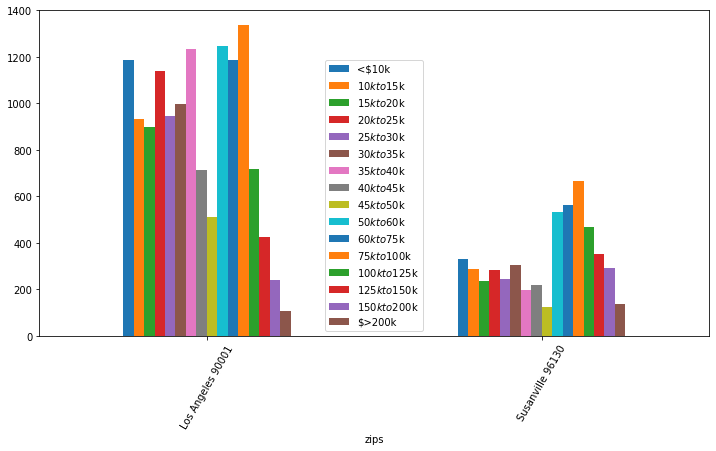

In [22]:
# let's get a histogram
zip90001 = zipdemo.loc[(zipdemo['Geo_ZCTA5'] == 90001) | (zipdemo['Geo_ZCTA5'] == 96130)]

income_start = zip90001.columns.get_loc('SE_A14001_002')
income_end = zip90001.columns.get_loc('SE_A14001_017') + 1
brackets = zip90001.iloc[:, income_start:income_end]
brackets["zips"] = ["Los Angeles 90001", "Susanville 96130"]

labels = ["<$10k","$10k to $15k","$15k to $20k","$20k to $25k","$25k to $30k","$30k to $35k","$35k to $40k","$40k to $45k","$45k to $50k","$50k to $60k","$60k to $75k","$75k to $100k","$100k to $125k","$125k to $150k","$150k to $200k","$>200k"]
brackets.plot(kind="bar", x="zips", figsize=(12,6), rot=60).legend(labels)

There's a lot to look at in that dataset, but certainly all the key indicators about the zip should give us at least some picture of what the housing market there might look like.

##### Condensing Sale Data to Year

In [23]:
#remove month from "Month of Period End"
only_year_query = """SELECT "Zip Code" as zip_code, 
                    SUBSTR("Month of Period End" ,-4) as year,
                    "Median Sale Price" as med_sale_price,
                    "Homes Sold" as home_sold,
                    "New Listings" as new_listings,
                    "Inventory" as inventory,
                    "Days on Market" as days_on_market,
                    "Average Sale To List" as avg_sale_to_list,
                    PSSF as ppsf
                    FROM merged_sales"""
only_year = ps.sqldf(only_year_query, locals())

#group by year
cond_year_query = """SELECT zip_code, 
                            year,
                            AVG(med_sale_price) as med_sale_price,
                            SUM(home_sold) as homes_sold,
                            SUM(new_listings) as new_listings,
                            AVG(inventory) as inventory,
                            AVG(days_on_market) as days_on_market,
                            AVG(avg_sale_to_list) as avg_sale_to_list,
                            AVG(ppsf) as ppsf
                    FROM only_year
                    GROUP BY year, zip_code"""
cond_year = ps.sqldf(cond_year_query, locals())

#filtering to 2018
year_18_query = """SELECT *
                    FROM cond_year
                    WHERE year = '2018' """
year_18 = ps.sqldf(year_18_query, locals())

### 2018 Sales and Demographic data

In [24]:
#zip code = Geo_ZCTA5

sales_demo_query = """SELECT year_18.*, zipdemo.*
                    FROM year_18
                    INNER JOIN zipdemo on zip_code = Geo_ZCTA5
                    """
sales_demo = ps.sqldf(sales_demo_query, locals())
sales_demo

,zip_code,year,med_sale_price,homes_sold,new_listings,inventory,days_on_market,avg_sale_to_list,ppsf,Geo_FIPS,...,SE_A08002B_005,SE_A08002B_006,SE_A10066_001,SE_A10066_002,SE_A10066_003,SE_A10066_004,SE_A10066_005,SE_A10066_006,SE_A10066_007,SE_A10066_008
0,90001,2018,422833.3333,511,678.0000,44.3333,43.1667,100.1250,322.5000,90090001,...,144,118,13815,1834,2083,2594,2513,2045,1330,1416
1,90002,2018,382500.0000,964,1178.0000,74.6667,39.9167,99.9167,323.7500,90090002,...,45,124,12706,2096,2232,2020,2266,1719,895,1478
2,90003,2018,407666.6667,962,1222.0000,96.0000,45.4167,99.9333,314.1667,90090003,...,193,129,17127,2594,2479,2966,3345,2757,1476,1510
3,90004,2018,1286500.0000,747,1117.0000,85.8333,33.8333,99.2333,630.9167,90090004,...,483,463,21971,6379,6385,3842,2854,1539,721,251
4,90005,2018,771000.0000,314,446.0000,30.6667,30.2500,99.2250,523.0000,90090005,...,431,380,16442,6298,4939,2183,1794,832,293,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,96146,2018,580750.0000,249,368.0000,62.6667,163.3333,95.6917,486.3333,96196146,...,0,9,454,152,215,31,24,32,0,0
1333,96148,2018,644083.3333,155,156.0000,14.5833,90.5000,96.9500,413.6667,96196148,...,24,0,210,55,62,6,50,26,0,11
1334,96150,2018,453666.6667,2333,3039.0000,246.3333,43.7500,97.0083,307.6667,96196150,...,461,24,11536,3645,4315,1666,1221,427,202,60
1335,96155,2018,234000.0000,8,nan,nan,104.0000,91.3333,145.6667,96196155,...,0,0,0,0,0,0,0,0,0,0


In [25]:
#create avg_sale_to_list groups (split into 5)
ntile_DoM_query = """SELECT *, NTILE(5) OVER (
                            ORDER BY days_on_market ASC) as DoM_group      
                        FROM sales_demo"""
ntile_DoM = ps.sqldf(ntile_DoM_query, locals())


#see group maximums
minmax_DoM_query = """SELECT DoM_group, COUNT(zip_code), MAX(days_on_market)
                        FROM ntile_DoM
                        GROUP BY DoM_group"""
minmax_DoM = ps.sqldf(minmax_DoM_query, locals())
minmax_DoM

,DoM_group,COUNT(zip_code),MAX(days_on_market)
0,1,268,21.4167
1,2,268,34.7500
2,3,267,44.0833
3,4,267,59.4167
4,5,267,2833.0000


In [26]:
#Delete non-numeric columns.
del_col = ['Geo_FIPS', 'Geo_GEOID', 'Geo_NAME', 'Geo_QName', 'Geo_STUSAB', 'Geo_SUMLEV', 
           'Geo_GEOCOMP', 'Geo_FILEID', 'Geo_LOGRECNO', 'Geo_US', 'Geo_REGION', 'Geo_DIVISION', 
          'Geo_STATECE', 'Geo_STATE', 'Geo_COUNTY', 'Geo_COUSUB', 'Geo_PLACE', 'Geo_PLACESE', 
          'Geo_TRACT', 'Geo_BLKGRP', 'Geo_CONCIT', 'Geo_AIANHH', 'Geo_AIANHHFP', 'Geo_AIHHTLI', 
          'Geo_AITSCE', 'Geo_AITS', 'Geo_ANRC', 'Geo_CBSA', 'Geo_CSA', 'Geo_METDIV', 'Geo_MACC', 
          'Geo_MEMI', 'Geo_NECTA', 'Geo_CNECTA', 'Geo_NECTADIV', 'Geo_UA', 'Geo_UACP', 'Geo_CDCURR', 
          'Geo_SLDU', 'Geo_SLDL', 'Geo_VTD', 'Geo_ZCTA3', 'Geo_SUBMCD', 'Geo_SDELM', 'Geo_SDSEC', 
          'Geo_SDUNI', 'Geo_UR', 'Geo_PCI', 'Geo_TAZ', 'Geo_UGA', 'Geo_BTTR', 'Geo_BTBG', 
          'Geo_PUMA5', 'Geo_PUMA1', 'year','Geo_ZCTA5']
for i in del_col:
    del ntile_DoM[i]

### Building the Model

In [52]:
# Set variables to hold test and training data.

# Shuffle data frame.
shuffled = ntile_DoM.sample(frac=1).reset_index(drop=True)

# Remove blanks and NaNs
shuffled.replace('', np.nan)
shuffled = shuffled.dropna(axis=0, how='any')

# Split into data and labels.
labels = shuffled["DoM_group"]
del shuffled["DoM_group"]
zip_codes = shuffled["zip_code"]
del shuffled["zip_code"]
shuffled = shuffled.apply(lambda x: pd.to_numeric(x))

# Create 80% split point.
split = int(len(shuffled)*0.8//1)

# Store in variables.
train_data = shuffled[:split]
train_labels = labels[:split]
test_data = shuffled[split+1:]
test_labels = labels[split+1:]

In [53]:
# Build KNN Model with various k values
k_values = [1, 3, 5, 7, 9, 21, 201, len(train_data)]

for i, k in enumerate(k_values):
        # Build the models using values from the k_values list.
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(train_data, train_labels)

        # Test model using dev data.
        predicted_labels = model.predict(test_data)

        # Show the classification report for k=1 only.
        if k==1:
            print("Classification report for k=1:\n", classification_report(test_labels, predicted_labels))

        # Calculate number of incorrect values for each model.
        num_wrong = sum(test_labels != predicted_labels)
        accuracy = (len(test_labels) - num_wrong) / len(test_labels)
        print("k=%d \t Model Accuracy: %.3f  "  % (k ,accuracy))    

Classification report for k=1:
               precision    recall  f1-score   support

           1       0.48      0.44      0.46        25
           2       0.43      0.45      0.44        20
           3       0.32      0.47      0.38        15
           4       0.28      0.23      0.25        22
           5       0.50      0.25      0.33         4

    accuracy                           0.38        86
   macro avg       0.40      0.37      0.37        86
weighted avg       0.39      0.38      0.38        86

k=1 	 Model Accuracy: 0.384  
k=3 	 Model Accuracy: 0.419  
k=5 	 Model Accuracy: 0.442  
k=7 	 Model Accuracy: 0.384  
k=9 	 Model Accuracy: 0.407  
k=21 	 Model Accuracy: 0.407  
k=201 	 Model Accuracy: 0.209  
k=345 	 Model Accuracy: 0.174  


In [54]:
# Gaussian NB Model.
for i in np.arange(0.1, 1, 0.1):
    model = GaussianNB(var_smoothing=i)
    model.fit(train_data, train_labels)

    predicted_labels = model.predict(test_data)

    num_wrong = sum(test_labels != predicted_labels)
    accuracy = (len(test_labels) - num_wrong) / len(test_labels)
    print(round(i,1), round(accuracy, 4))

0.1 0.2558
0.2 0.2558
0.3 0.2558
0.4 0.2326
0.5 0.2209
0.6 0.2209
0.7 0.2209
0.8 0.2209
0.9 0.2209


## Standardize Data and Remodel

In [68]:
# Standardize columns
train_data_std = train_data.apply(lambda x: (x - x.mean()) / x.std())
train_data_mean = train_data.apply(lambda x: x.mean())
train_data_sd = train_data.apply(lambda x: x.std())

# Impart on test data.
test_data_std = (test_data - train_data_mean)/train_data_sd

In [69]:
# Build KNN Model with various k values
k_values = [1, 3, 5, 7, 9, 21, 201, len(train_data)]

for i, k in enumerate(k_values):
        # Build the models using values from the k_values list.
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(train_data_std, train_labels)

        # Test model using dev data.
        predicted_labels = model.predict(test_data_std)

        # Show the classification report for k=1.
        if k==1:
            print("Classification report for k=1:\n", classification_report(test_labels, predicted_labels))

        # Calculate number of incorrect values for each model.
        num_wrong = sum(test_labels != predicted_labels)
        accuracy = (len(test_labels) - num_wrong) / len(test_labels)
        print("k=%d \t Model Accuracy: %.3f  "  % (k ,accuracy))    

Classification report for k=1:
               precision    recall  f1-score   support

           1       0.69      0.80      0.74        25
           2       0.59      0.50      0.54        20
           3       0.35      0.60      0.44        15
           4       0.36      0.23      0.28        22
           5       0.00      0.00      0.00         4

    accuracy                           0.51        86
   macro avg       0.40      0.43      0.40        86
weighted avg       0.49      0.51      0.49        86

k=1 	 Model Accuracy: 0.512  
k=3 	 Model Accuracy: 0.442  
k=5 	 Model Accuracy: 0.488  
k=7 	 Model Accuracy: 0.488  
k=9 	 Model Accuracy: 0.512  
k=21 	 Model Accuracy: 0.384  
k=201 	 Model Accuracy: 0.279  
k=345 	 Model Accuracy: 0.174  


/Users/duncanhoward/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [70]:
# Gaussian NB Model.
model = GaussianNB(var_smoothing=0)
model.fit(train_data_std, train_labels)

predicted_labels = model.predict(test_data_std)

num_wrong = sum(test_labels != predicted_labels)
accuracy = (len(test_labels) - num_wrong) / len(test_labels)

print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           1       0.73      0.76      0.75        25
           2       0.50      0.35      0.41        20
           3       0.35      0.40      0.38        15
           4       0.62      0.23      0.33        22
           5       0.14      0.75      0.24         4

    accuracy                           0.47        86
   macro avg       0.47      0.50      0.42        86
weighted avg       0.56      0.47      0.47        86



## Scale to increase weight of non-demographic data

In [71]:
# Non-demographic data is in the first 7 columns
print((train_data_std.columns[0:7]))

Index(['med_sale_price', 'homes_sold', 'new_listings', 'inventory',
       'days_on_market', 'avg_sale_to_list', 'ppsf'],
      dtype='object')


In [72]:
# Multiply by a scalar.
scale_factor = 10
train_data_std[0:7] = train_data_std[0:7].multiply(scale_factor)
test_data_std[0:7] = test_data_std[0:7].multiply(scale_factor)

In [73]:
# Build KNN Model with various k values
k_values = [1, 3, 5, 7, 9, 21, 201, len(train_data)]

for i, k in enumerate(k_values):
        # Build the models using values from the k_values list.
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(train_data_std, train_labels)

        # Test model using dev data.
        predicted_labels = model.predict(test_data_std)

        # Show the classification report for k=1.
        if k==1:
            print("Classification report for k=1:\n", classification_report(test_labels, predicted_labels))

        # Calculate number of incorrect values for each model.
        num_wrong = sum(test_labels != predicted_labels)
        accuracy = (len(test_labels) - num_wrong) / len(test_labels)
        print("k=%d \t Model Accuracy: %.3f  "  % (k ,accuracy))    

Classification report for k=1:
               precision    recall  f1-score   support

           1       0.71      0.80      0.75        25
           2       0.61      0.55      0.58        20
           3       0.35      0.53      0.42        15
           4       0.35      0.27      0.31        22
           5       0.00      0.00      0.00         4

    accuracy                           0.52        86
   macro avg       0.41      0.43      0.41        86
weighted avg       0.50      0.52      0.51        86

k=1 	 Model Accuracy: 0.523  
k=3 	 Model Accuracy: 0.465  
k=5 	 Model Accuracy: 0.488  
k=7 	 Model Accuracy: 0.512  
k=9 	 Model Accuracy: 0.523  
k=21 	 Model Accuracy: 0.395  
k=201 	 Model Accuracy: 0.279  
k=345 	 Model Accuracy: 0.174  


/Users/duncanhoward/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [81]:
# Gaussian NB Model.
model = GaussianNB(var_smoothing=0)
model.fit(train_data_std, train_labels)

predicted_labels = model.predict(test_data_std)

num_wrong = sum(test_labels != predicted_labels)
accuracy = (len(test_labels) - num_wrong) / len(test_labels)

print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           1       0.70      0.28      0.40        25
           2       0.25      0.10      0.14        20
           3       0.00      0.00      0.00        15
           4       0.23      0.41      0.30        22
           5       0.12      0.75      0.21         4

    accuracy                           0.24        86
   macro avg       0.26      0.31      0.21        86
weighted avg       0.33      0.24      0.23        86

